# Erwan LeCun
# PUI_HW5-1_ErwanLeCun

In [1]:
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nrg = gp.GeoDataFrame.from_csv(os.path.expandvars('$PUI2015/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv'))

In [20]:
bsize = gp.GeoDataFrame.from_file(os.path.expandvars("$PUI2015/Manhattan/MNMapPLUTO.shp"))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1330fde10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13012e210>]], dtype=object)

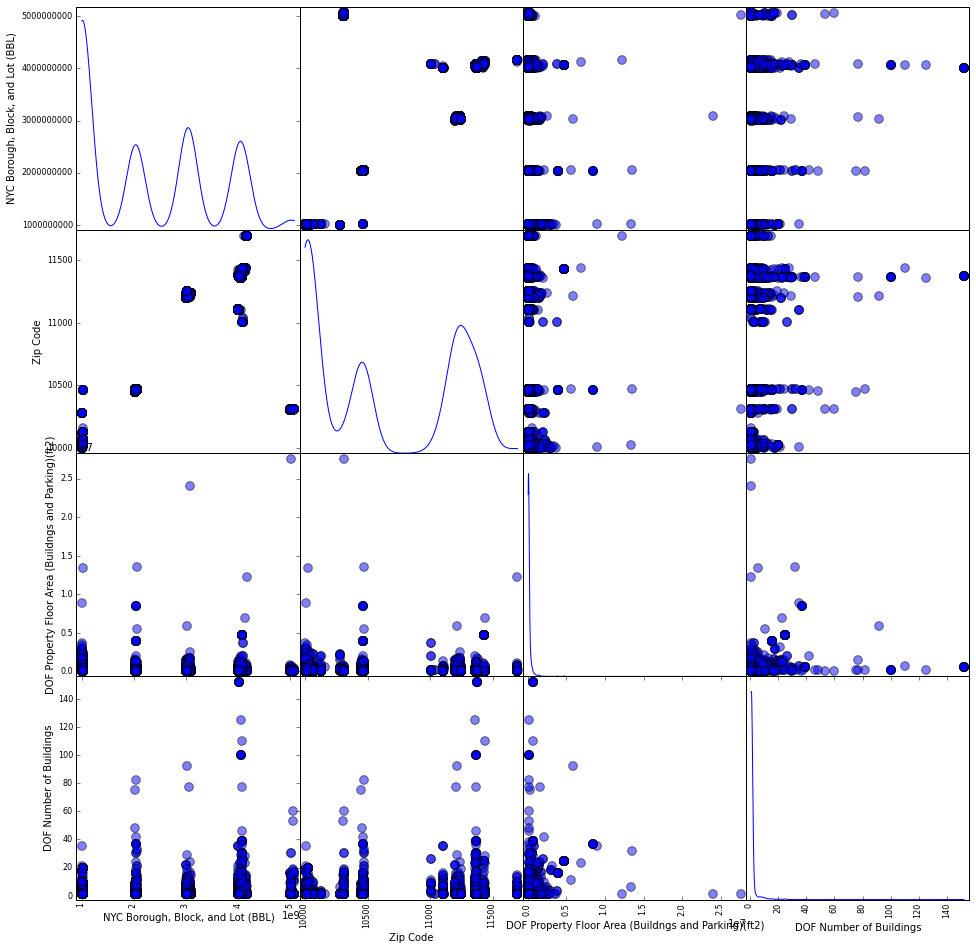

In [4]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), diagonal='kde')

In [5]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

In [6]:
vfunc = np.vectorize(canconvert)
indx = vfunc(nrg['Site EUI(kBtu/ft2)'])
indx2 = vfunc(nrg['Reported Property Floor Area (Building(s)) (ft²)'])

In [7]:
nrg['Site EUI(kBtu/ft2)'][~indx]=float('NaN')
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx2]=float('NaN')

/Users/erwan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/erwan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [8]:
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']

bblnrgdata = pd.merge(nrg, bsize, on=['BBL'])

bblnrgdata['Site EUI(kBtu/ft2)'] = bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

bblnrgdata['energy_total'] = bblnrgdata['Site EUI(kBtu/ft2)'] * bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)']

/Users/erwan/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1695: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target.values)
/Users/erwan/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1049: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine
/Users/erwan/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1572: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(_values_from_object(key))


In [9]:
bblnrgdata_cut = bblnrgdata[(bblnrgdata.energy_total > 1000) &
                            (bblnrgdata.energy_total < 1e10) & 
                            (bblnrgdata.UnitsTotal > 5) & 
                            (bblnrgdata.UnitsTotal < 1000)]

### Total Units vs Total Energy

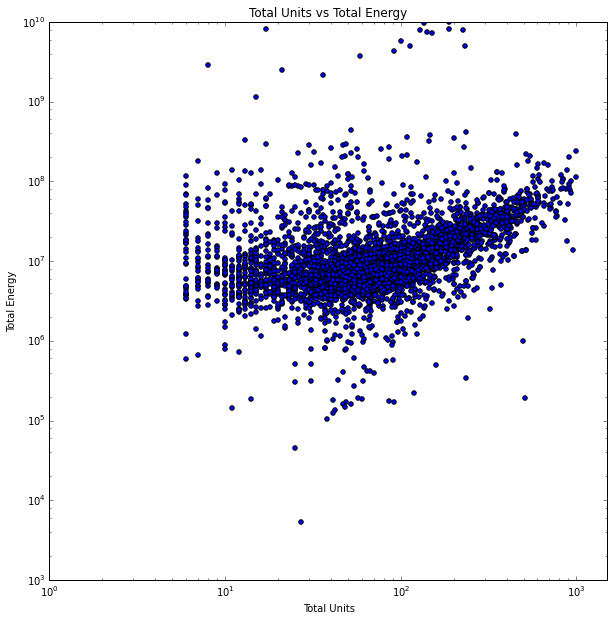

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Total Units')
ax.set_ylabel('Total Energy')
ax.set_title('Total Units vs Total Energy')
plt.xlim(1,1500)
plt.ylim(1000,1e10)
plt.scatter(bblnrgdata_cut['UnitsTotal'], bblnrgdata_cut['energy_total']) 

In [11]:
x = np.log10(bblnrgdata_cut['UnitsTotal'])
y = np.log10(bblnrgdata_cut['energy_total'])

data = pd.DataFrame({'x':x, 'y':y})
data.x = data.x.replace([np.inf, -np.inf], np.nan)
data.y = data.y.replace([np.inf, -np.inf], np.nan)

model = smf.ols(formula = 'y ~ x', data = data, missing = 'drop').fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     700.9
Date:                Fri, 16 Oct 2015   Prob (F-statistic):          2.51e-143
Time:                        01:03:02   Log-Likelihood:                -2324.2
No. Observations:                4350   AIC:                             4652.
Df Residuals:                    4348   BIC:                             4665.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.2947      0.028    223.991      0.0

### Total Units vs Total Energy (Line Fit)

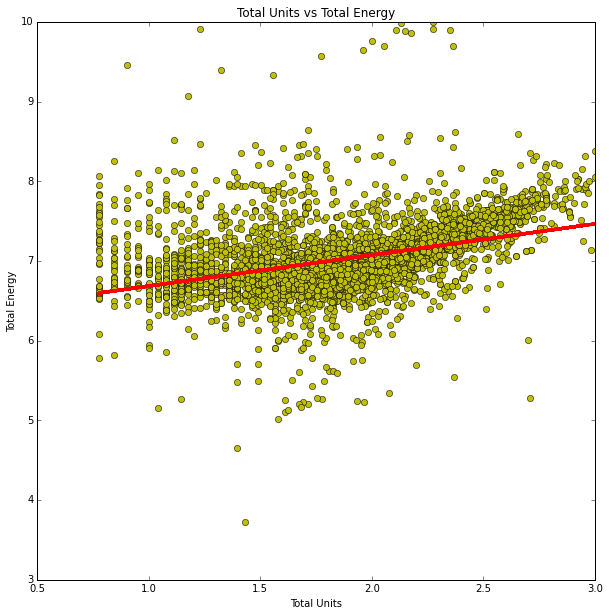

In [12]:
idx = np.isfinite(data.x) & np.isfinite(data.y)
m, b = np.polyfit(data.x[idx], data.y[idx], 1)

fig = plt.figure(figsize=(10, 10))
plt.plot(x, y, 'yo', x, m*x+b, 'r', linewidth = '3')
plt.xlabel('Total Units')
plt.ylabel('Total Energy')
plt.title('Total Units vs Total Energy')

### Total Energy vs Total Units

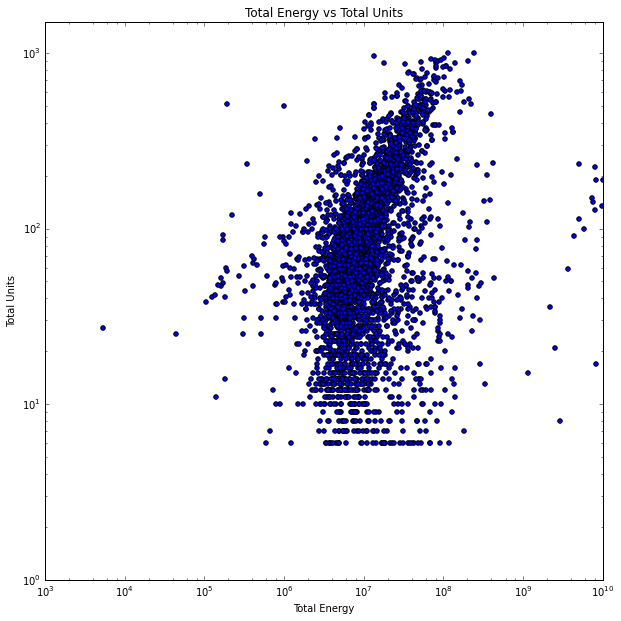

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Total Units')
ax.set_xlabel('Total Energy')
ax.set_title('Total Energy vs Total Units')
plt.ylim(1,1500)
plt.xlim(1000,1e10)
plt.scatter(bblnrgdata_cut['energy_total'], bblnrgdata_cut['UnitsTotal']) 

In [14]:
y = np.log10(bblnrgdata_cut['UnitsTotal'])
x = np.log10(bblnrgdata_cut['energy_total'])

data = pd.DataFrame({'x':x, 'y':y})
data.x = data.x.replace([np.inf, -np.inf], np.nan)
data.y = data.y.replace([np.inf, -np.inf], np.nan)
data.to_csv('regress.csv')

model = smf.ols(formula = 'y ~ x', data = data, missing = 'drop').fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     700.9
Date:                Fri, 16 Oct 2015   Prob (F-statistic):          2.51e-143
Time:                        01:03:03   Log-Likelihood:                -2123.0
No. Observations:                4350   AIC:                             4250.
Df Residuals:                    4348   BIC:                             4263.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.6387      0.095     -6.757      0.0

### Total Energy vs Total Units (Line Fit)

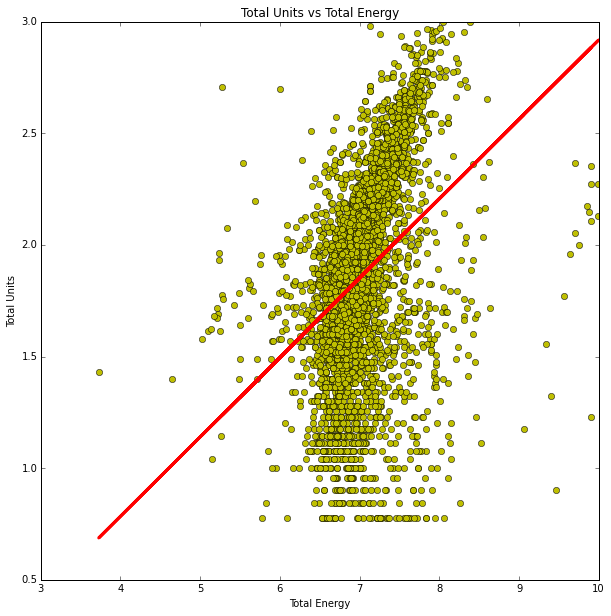

In [15]:
idx = np.isfinite(data.x) & np.isfinite(data.y)
m, b = np.polyfit(data.x[idx], data.y[idx], 1)

fig = plt.figure(figsize=(10, 10))
plt.plot(x, y, 'yo', x, m*x+b, 'r', linewidth = '3')
plt.ylabel('Total Units')
plt.xlabel('Total Energy')
plt.title('Total Units vs Total Energy')

## Neither fit is better, since all we did was swap the dependent and independent variables.
## The r-squared remains 0.139 for both. 
## We CAN NOT do a likelihood ratio test here because there are the same amount of parameters, leaving us with no degrees of freedom for the test.

### Total Units vs Total Energy (Second Degree Curve Fit)

In [16]:
x = np.log10(bblnrgdata_cut['UnitsTotal'])
y = np.log10(bblnrgdata_cut['energy_total'])

data = pd.DataFrame({'x':x, 'y':y})
data.x = data.x.replace([np.inf, -np.inf], np.nan)
data.y = data.y.replace([np.inf, -np.inf], np.nan)

idx = np.isfinite(data.x) & np.isfinite(data.y)
b2, b1, b0 = np.polyfit(data.x[idx], data.y[idx], 2)

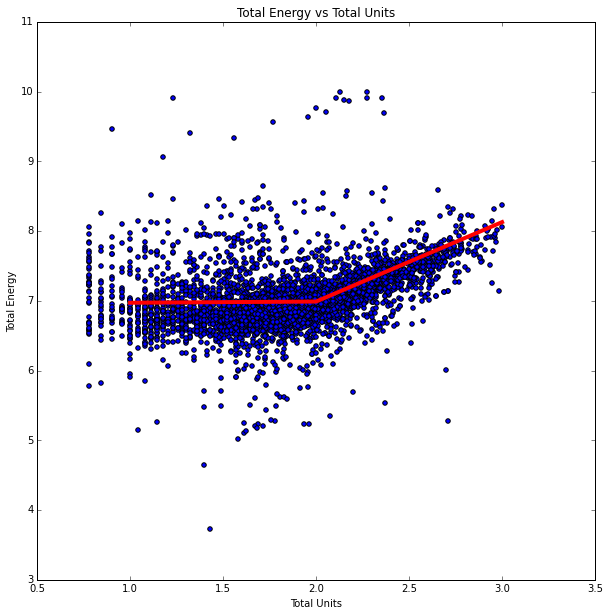

In [17]:
x_dum = np.array([1, 2, 3])
y_star = b2 * x_dum ** 2 + b1 * x_dum + b0

fig = plt.figure(figsize=(10, 10))
pl.plot(x_dum, y_star, 'r', linewidth = '4')
pl.scatter(x,y)
pl.xlabel('Total Units')
pl.ylabel('Total Energy')
pl.title('Total Energy vs Total Units')

In [18]:
model = smf.ols(formula='y ~ x + I(x**2)', data = data)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     678.8
Date:                Fri, 16 Oct 2015   Prob (F-statistic):          2.79e-257
Time:                        01:03:04   Log-Likelihood:                -2058.1
No. Observations:                4350   AIC:                             4122.
Df Residuals:                    4347   BIC:                             4141.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.0766      0.079    101.659      0.000         7.921     8.232
x             -1.6653      0.088    -19.026      0.000        -1.837    -1.494
I(x ** 2)      0.5608      0.024     23.784      0.000         0.515     0.607
==============================================================================
Omnibus:                     1581.668   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30396.154
Skew:                           1.245   Prob(JB):                         0.00
Kurtosis:                      15.708   Cond. No.                         91.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## The second degree curve fit is better, since it can capture the data more accurately.
## The r-squared for the curve is 0.238, while it is only 0.139 for the line. 
## We CAN do a likelihood ratio test here because there are different amounts of parameters between the two models, leaving us with adequate degrees of freedom for the test.

/Users/erwan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/erwan/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/erwan/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns

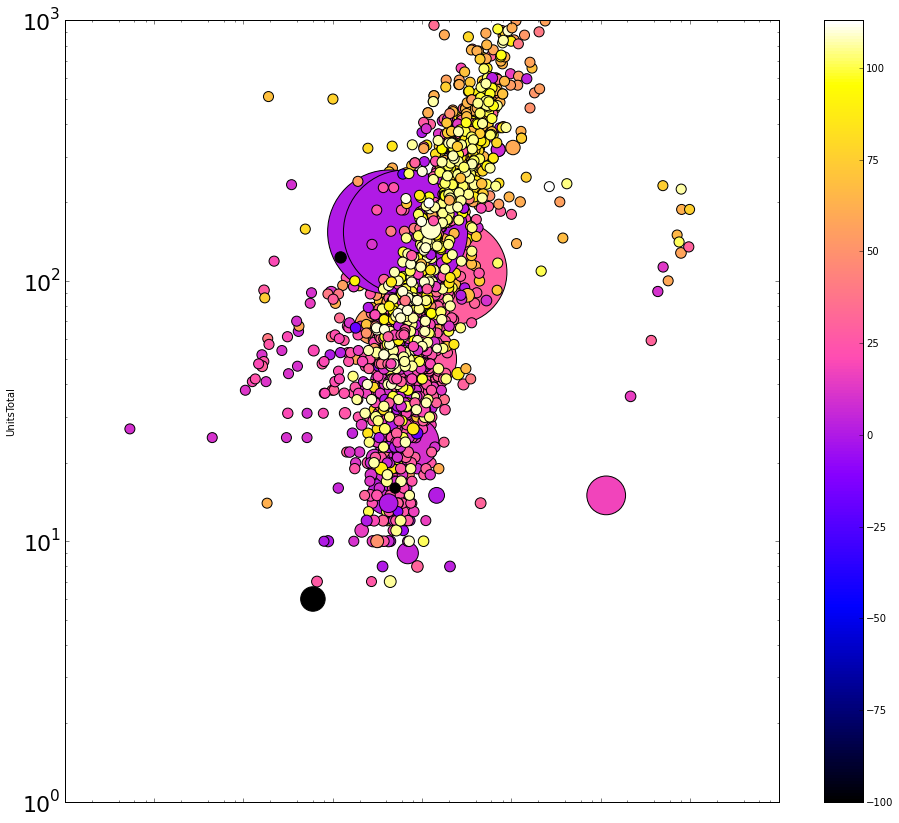

In [19]:
bblnrgdata_cut['YearBuilt'][bblnrgdata_cut['YearBuilt'] < 1800] = 1800

bblnrgdata_cut.plot(kind='scatter',x='energy_total',
                    y='UnitsTotal', fontsize=22, colormap='gnuplot2', 
                    alpha = 1, marker='o',  figsize=(16, 14), loglog=True,  
                    xlim=(1000,1e11), ylim=(1,1000), c=bblnrgdata_cut['YearBuilt']-1900, 
                    s=bblnrgdata_cut['UnitsTotal']/bblnrgdata_cut['UnitsRes']*100)